# Polarized CBO

The polarized version of CBO modifies the consensus computation such that every particle has its own version of the consensus point. This allows to find multiple global minima at the same time. In the following, we test the performance on a special test function, namely the snowflake.

In [1]:
%load_ext autoreload
%autoreload 2
from cbx.objectives import snowflake, Bimodal, Multimodal
from cbx.dynamics import PolarCBO
from cbx.plotting import PlotDynamicHistory, PlotDynamic
from cbx.scheduler import multiply
import matplotlib.pyplot as plt
import numpy as np

In the following, we first specify the hyperparameters and then run the dynamic.

In [2]:
np.random.seed(42)
f = snowflake()
N = 100
x = np.random.uniform(-2., 2., (2,N,2))

dyn = PolarCBO(
    f, x=x, alpha=1., sigma=2., kappa=1.5,
    batch_args={'size':50},
    verbosity=0,
    track_args={'names':[
        'x', 
        'consensus', 
        'drift']},
)
dyn.optimize(sched = multiply(factor=1.02, maximum=1e10))

array([[-2.40007460e-07,  1.66489879e+00],
       [ 1.00024121e-06, -1.68700984e+00]])

## Plotting the dynamic
We use the plotting functionality of ``cbx`` to visualize the history of the particles. Here, we can adjust the appearance to obtain an appropriate look ;).

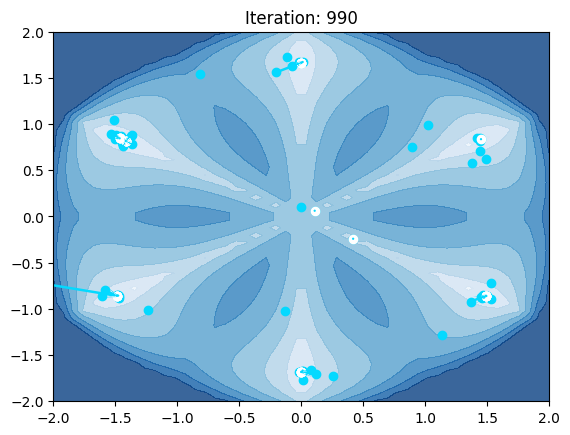

In [3]:
import matplotlib.pyplot as plt
from IPython import display

fig, ax = plt.subplots(1,)
pl = PlotDynamicHistory(
    dyn, ax=ax,
    objective_args={'x_min':-2, 'x_max':2, 'cmap':'Blues', 'alpha':0.8},
    particle_args={'color':'xkcd:neon blue'},
    consensus_args={'color':'white'},
    drift_args = {'scale':1, 'scale_units':'xy', 'angles':'xy', 'width':0.005, 'color':'xkcd:neon blue','headaxislength':0},
    plot_consensus=True,
    plot_drift=True
)
for i in range(0, pl.max_it, 10):
    display.clear_output(wait=True)
    pl.plot_at_ind(i)
    pl.decorate_at_ind(i)
    display.display(fig)
    plt.pause(0.1)

## Polarized Sampling

By changing the noise method, we can also use the polarized consensus computation for sampling.

In [4]:
f = Bimodal(a = [1., 3.], b = [-1.2, -2.5])
x = np.random.uniform(-5., 5., (1,400,2))

dyn = PolarCBO(
    f,x=x,alpha=1.,sigma=2.,kappa=1.2,verbosity=0,
    noise='sampling',
    max_it = 1000,
    track_args={'names':[
      'x', 
      'consensus', 
      'drift']},)
dyn.optimize(sched = None)

C:\Users\roithtim\Documents\Projects\CBXpy\cbx\objectives.py:629: RuntimeWarning: divide by zero encountered in log
  ret = -np.log(np.exp(-((x[...,0]-a[0])**2 + (x[...,1]-a[1])**2/0.2)) \


array([[1.00449909, 3.00156505]])

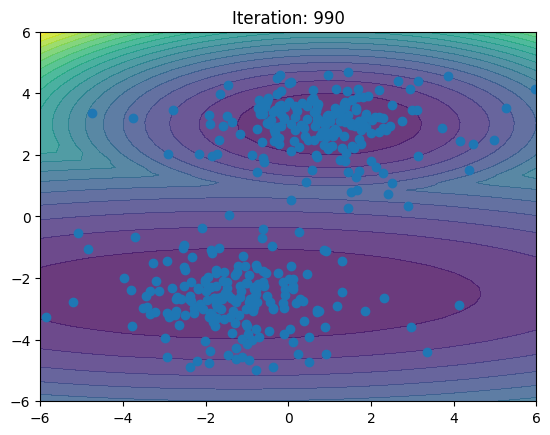

In [5]:
import matplotlib.pyplot as plt
from IPython import display

fig, ax = plt.subplots(1,)
pl = PlotDynamicHistory(
    dyn, ax=ax,
    objective_args={'x_min':-6, 'x_max':6., 'alpha':0.8, 'levels':20},
)
for i in range(0, pl.max_it, 10):
    display.clear_output(wait=True)
    pl.plot_at_ind(i)
    pl.decorate_at_ind(i)
    display.display(fig)
    plt.pause(0.1)

In [15]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

class GM_kernel:
    def __init__(self, n_components=2, kappa=1, max_evals=20, criterion='soft'):
        self.n_components=n_components
        self.evals = 0
        self.max_evals = max_evals
        self.kappa = kappa
        self.criterion = criterion
        
    def init_GM(self,):
        self.GM = GaussianMixture(n_components=self.n_components, warm_start=True)
        #self.GM = BayesianGaussianMixture(n_components=self.n_components, warm_start=True)
    
    def neg_log(self, x, y):
        if self.evals % self.max_evals == 0 and self.evals < 3*self.max_evals:
            self.init_GM()
        self.evals+=1
        neg_log = np.zeros((y.shape[0], y.shape[1], y.shape[1]))
        for m in range(x.shape[0]):
            self.GM.fit(x[m].squeeze())
            if self.criterion == 'hard':
                pred = self.GM.predict(y[m].squeeze())
                pred = np.equal.outer(pred, pred)
                neg_log[m, ~pred] = np.inf
            else:
                pred = self.GM.predict_proba(y[m].squeeze())
                neg_log[m] = pred@pred.T
        #dist = np.true_divide(1, 2*self.kappa**2) * ((x-y)**2).sum(tuple(i for i in range(3, x.ndim)))
        #ret = dist
        return neg_log
        

## Plotting Routines

In [7]:
import matplotlib as mpl
def init_ells(n, ax, color='orange'):
    ells = []
    for i in range(n):
        ell = mpl.patches.Ellipse(np.random.uniform(size=(2,)), 1., 1., angle=.0, color=color)
        ell.set_alpha(0.5)
        ells.append(ell)
        ax.add_artist(ell)
    return ells

def update_ells(means, covars, ells):
    for i, (mean, covar,) in enumerate(zip(means, covars)):
        v, w = np.linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle)
        ell.set_clip_box(ax.bbox)
        ells[i].set_center(ell.center)
        ells[i].set_width(ell.width)
        ells[i].set_height(ell.height)
        ells[i].set_angle(ell.angle)

        # this didn't work: ells[i].update_from(ell)

In [26]:
from cbx.dynamics import CBS
np.random.seed(100)
fig, ax = plt.subplots(1,)
x = np.random.uniform(-5., 5., (1,500,2))
nc = 4
covs = [np.random.uniform(size=(2,2)) for _ in range(nc)]
f = Multimodal(means = [np.random.uniform(-5,5,size=(2,)) for _ in range(nc)], covs = [0.5*(0.5*(A + A.T) + np.eye(2)) for A in covs])
dyn = PolarCBO(
    f,x=x,alpha=10.,sigma=1.,verbosity=0,
    dt=0.1,
    noise='sampling',
    kernel = GM_kernel(n_components=nc,kappa=1.5, criterion='hard',max_evals=50),
    max_it = 1000,)
pl = PlotDynamic(dyn, ax=ax, objective_args={'x_min':-6, 'x_max':6., 'alpha':0.8, 'levels':20},)
pl.init_plot()
ells = init_ells(nc, ax, color='red')
update_ells(f.means, f.covs, ells)
# dyn = CBS(
#    f,x=x,alpha=10,verbosity=0,
#    mode = 'sampling',
#    max_it = 1000,)


ells = init_ells(nc, ax)
while not dyn.terminate():
    display.clear_output(wait=True)
    dyn.step()
    pl.update(wait=0.01)
    update_ells(dyn.kernel.GM.means_, dyn.kernel.GM.covariances_, ells)
    plt.show()
    display.display(fig)

    # if dyn.it % dyn.kernel.max_evals == 0:
    #     dyn.x[0] = dyn.kernel.GM.sample(dyn.N)[0]
    #     print('Resampled')

KeyboardInterrupt: 

In [ ]:
dyn

In [ ]:
ell = mpl.patches.Ellipse(np.random.uniform((2,)), 2., 3., angle=180.0)
ell.set_clip_box(ax.bbox)
ells[0].set_width([4,5])

In [ ]:
ells[0].width

In [ ]:
weights = - self.kernel_factor() * self.neg_log_eval - self.alpha * self.energy
coeffs = np.exp(weights - logsumexp(weights, axis=(-1,), keepdims=True))

D = self.drift[...,None] * self.drift[...,None,:]
D = np.sum(D * coeffs[..., None, None], axis = -3)

In [ ]:
weights[0,-3,...]

In [ ]:
neg_log = np.zeros((x.shape[0], x.shape[1], x.shape[1]))
a = GM.fit_predict(dyn.x[0,...])

In [ ]:
pred = np.equal.outer(a,a)

In [ ]:
neg_log[0, ~pred]=-np.inf

In [ ]:
neg_log

In [ ]:
pred

In [ ]:
0*np.inf